### Các thư viện

In [2]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
import matplotlib.pyplot as plt

### Đọc file

In [3]:
# Đọc dữ liệu
df = pd.read_csv("D:/PPNC---Comparing-Machine-Learning-Models-for-AQI-Prediction-in-HCMC-Th-/Data/DATASET_state_weather_aqi_data_PPNC.csv")

### Định nghĩa hàm tính RMSLE

In [4]:
# Định nghĩa hàm tính RMSLE
def rmsle(real, predicted):
    sum = 0.0
    real = np.ravel(real) if hasattr(real, 'shape') and len(real.shape) > 1 else real
    predicted = np.ravel(predicted) if hasattr(predicted, 'shape') and len(predicted.shape) > 1 else predicted
    
    for x in range(len(predicted)):
        if predicted[x] < 0 or real[x] < 0:
            continue
        p = np.log(predicted[x] + 1)
        r = np.log(real[x] + 1)
        sum = sum + (p - r) ** 2
    return (sum / len(predicted)) ** 0.5

### Xác định cột và giá trị

In [5]:
# Xác định các cột cần dùng
categorical_features = ['City', 'district']  # Đặc trưng phân loại
numerical_features = ['PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'OZONE']  # Đặc trưng số
target = 'AQI'

# Kiểm tra giá trị NaN trong các cột cần thiết
all_features = categorical_features + numerical_features + [target]
print("\nSố lượng giá trị NaN trong các cột:")
print(df[all_features].isnull().sum())

# Loại bỏ các dòng có giá trị NaN trong các cột cần thiết
df_clean = df.dropna(subset=all_features)
print(f"\nSố lượng dòng sau khi loại bỏ NaN: {len(df_clean)}")

# One-hot encoding cho các đặc trưng phân loại
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categorical_data = ohe.fit_transform(df_clean[categorical_features])
categorical_df = pd.DataFrame(
    categorical_data, 
    columns=ohe.get_feature_names_out(categorical_features)
)

# Kết hợp các đặc trưng đã mã hóa và đặc trưng số
feature_set = pd.concat([categorical_df.reset_index(drop=True), 
                         df_clean[numerical_features].reset_index(drop=True)], axis=1)
y = df_clean[target].values

print(f"Kích thước feature_set: {feature_set.shape}")
print(f"Kích thước y: {y.shape}")



Số lượng giá trị NaN trong các cột:
City          0
district      0
PM2.5       173
PM10        337
NO2         155
NH3         444
SO2         213
CO           63
OZONE       149
AQI           0
dtype: int64

Số lượng dòng sau khi loại bỏ NaN: 966
Kích thước feature_set: (966, 24)
Kích thước y: (966,)


## PHẦN 1: Đánh giá mô hình Linear Regression dựa trên AQI

In [6]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(feature_set, y, test_size=0.2, random_state=0)

In [7]:
# Huấn luyện và đánh giá mô hình Linear Regression
print("\nHuấn luyện mô hình Linear Regression...")

# Chuẩn hóa dữ liệu
sc_X = StandardScaler()
sc_y = StandardScaler()
X_train_lr = sc_X.fit_transform(X_train)
y_train_lr = sc_y.fit_transform(y_train.reshape(-1, 1)).ravel()

# Huấn luyện
lr_model = LinearRegression()
lr_model.fit(X_train_lr, y_train_lr)

# Dự đoán
X_test_lr = sc_X.transform(X_test)
lr_y_predict = sc_y.inverse_transform(lr_model.predict(X_test_lr).reshape(-1, 1))
lr_train_predict = sc_y.inverse_transform(lr_model.predict(X_train_lr).reshape(-1, 1))


Huấn luyện mô hình Linear Regression...


Sau khi tiến hành huấn luyện mô hình Linear Regression với dữ liệu đã được chuẩn hóa bằng StandardScaler, mô hình cho thấy hiệu suất dự đoán tương đối ấn tượng, đặc biệt trong bối cảnh bài toán dự đoán chỉ số chất lượng không khí (AQI). Việc sử dụng chuẩn hóa đảm bảo rằng các đặc trưng không bị ảnh hưởng bởi đơn vị đo khác nhau, từ đó tăng độ ổn định và giúp mô hình hội tụ tốt hơn trong quá trình học.

Cụ thể, dữ liệu được chia thành 80% cho huấn luyện và 20% cho kiểm tra bằng phương pháp train_test_split. Sau khi huấn luyện, mô hình được đánh giá thông qua việc dự đoán giá trị AQI trên cả hai tập – huấn luyện và kiểm tra – từ đó kiểm tra khả năng tổng quát hóa của mô hình.

Kết quả đánh giá cho thấy Linear Regression đạt hiệu năng rất cao, với hệ số xác định R² lần lượt đạt 0.9843 trên tập huấn luyện và 0.9712 trên tập kiểm tra, phản ánh khả năng giải thích phương sai dữ liệu vượt trội. Đồng thời, các chỉ số sai số như RMSE, MAE, và RMSLE đều ở mức thấp (ví dụ: RMSE kiểm tra ≈ 15.82, RMSLE kiểm tra ≈ 0.13), cho thấy mô hình có độ lệch trung bình giữa giá trị dự đoán và thực tế rất nhỏ.

Mặc dù Linear Regression là một mô hình tuyến tính đơn giản và không xử lý tốt các mối quan hệ phi tuyến, nhưng trong trường hợp này, mô hình vẫn hoạt động tốt nhờ đặc trưng của dữ liệu đã được xử lý hợp lý. Ưu điểm nổi bật của Linear Regression là tốc độ huấn luyện nhanh, khả năng diễn giải tốt và dễ triển khai. Tuy nhiên, mô hình vẫn có giới hạn khi gặp phải dữ liệu có tính phi tuyến cao hoặc nhiều tương tác phức tạp giữa các đặc trưng.

Tổng thể, Linear Regression là một mô hình đáng tin cậy cho bài toán dự đoán AQI nếu dữ liệu đầu vào được xử lý cẩn thận. Mặc dù không thể so sánh về độ linh hoạt với các mô hình phi tuyến như XGBoost hay SVR, nhưng Linear Regression vẫn cung cấp hiệu suất ấn tượng với chi phí tính toán thấp, đặc biệt trong các ứng dụng yêu cầu sự đơn giản và minh bạch trong kết quả dự đoán.

In [8]:
# Đánh giá mô hình Linear Regression trên tập huấn luyện
lr_ytp_r2 = float(r2_score(y_train, lr_train_predict))
lr_ytp_rmse = float(sqrt(mean_squared_error(y_train, lr_train_predict)))
lr_ytp_mae = float(mean_absolute_error(y_train, lr_train_predict))
lr_ytp_rmsle = float(np.sqrt(mean_squared_error(np.log1p(y_train), np.log1p(lr_train_predict))))
lr_ytp_mse = float(mean_squared_error(y_train, lr_train_predict))

# Đánh giá trên tập kiểm tra
r2_lr = float(r2_score(y_test, lr_y_predict))
rmse_lr = float(sqrt(mean_squared_error(y_test, lr_y_predict)))
mae_lr = float(mean_absolute_error(y_test, lr_y_predict))
rmsle_lr = float(np.sqrt(mean_squared_error(np.log1p(y_test), np.log1p(lr_y_predict))))
mse_lr = float(mean_squared_error(y_test, lr_y_predict))

Trên tập huấn luyện, mô hình đạt được hệ số xác định R² = 0.9843, cho thấy mức độ giải thích biến thiên của dữ liệu ở mức rất cao. Các chỉ số sai số khác như:

RMSE = 12.3211

MAE = 8.6809

MSE = 151.8085

RMSLE = 0.1016

đều thể hiện sai số dự đoán trung bình giữa giá trị thực và giá trị dự đoán là nhỏ, cho thấy mô hình học được mối quan hệ tuyến tính một cách khá chính xác từ dữ liệu huấn luyện. Với đặc trưng là một mô hình có tham số và dạng tuyến tính, Linear Regression dễ rơi vào hiện tượng quá khớp nếu dữ liệu quá phức tạp, tuy nhiên kết quả trên cho thấy hiện tượng này chưa xảy ra đáng kể trong bài toán hiện tại.

Khi đánh giá trên tập kiểm tra, mô hình tiếp tục thể hiện hiệu suất tốt với hệ số xác định R² = 0.9712, chỉ giảm nhẹ so với tập huấn luyện. Điều này phản ánh khả năng tổng quát hóa tốt của mô hình. Các chỉ số sai số trên tập kiểm tra cũng được duy trì ở mức thấp:

RMSE = 15.8241

MAE = 9.7565

MSE = 250.4031

RMSLE = 0.1301

Những kết quả này cho thấy mô hình Linear Regression không chỉ học tốt từ dữ liệu huấn luyện mà còn duy trì được độ chính xác khi dự đoán trên dữ liệu mới. Đây là minh chứng cho việc chuẩn hóa dữ liệu đã giúp cải thiện đáng kể hiệu suất và độ ổn định của mô hình.

In [9]:
# Hiển thị kết quả
print("\nĐánh giá trên dữ liệu huấn luyện:")
print("---------------------------------")
print("Mô hình\t\tR^2\tRMSE\tMAE\tRMSLE\tMSE")
print("Linear Reg\t{0:.4f}\t{1:.4f}\t{2:.4f}\t{3:.4f}\t{4:.4f}".format(lr_ytp_r2, lr_ytp_rmse, lr_ytp_mae, lr_ytp_rmsle, lr_ytp_mse))

print("\nĐánh giá trên dữ liệu kiểm tra:")
print("---------------------------------")
print("Mô hình\t\tR^2\tRMSE\tMAE\tRMSLE\tMSE")
print("Linear Reg\t{0:.4f}\t{1:.4f}\t{2:.4f}\t{3:.4f}\t{4:.4f}".format(r2_lr, rmse_lr, mae_lr, rmsle_lr, mse_lr))


Đánh giá trên dữ liệu huấn luyện:
---------------------------------
Mô hình		R^2	RMSE	MAE	RMSLE	MSE
Linear Reg	0.9843	12.3211	8.6809	0.1016	151.8085

Đánh giá trên dữ liệu kiểm tra:
---------------------------------
Mô hình		R^2	RMSE	MAE	RMSLE	MSE
Linear Reg	0.9712	15.8241	9.7565	0.1301	250.4031


Kết quả tốt trên cả hai tập:

Huấn luyện: R² = 0.9843

Kiểm tra: R² = 0.9712

Các chỉ số RMSE, MAE, và RMSLE đều ở mức thấp, cho thấy mô hình Linear Regression hoạt động hiệu quả và có độ chính xác cao trong việc dự đoán chỉ số chất lượng không khí (AQI).

Tuy có sự chênh lệch nhẹ giữa tập huấn luyện và kiểm tra, nhưng mức độ này không lớn, phản ánh mô hình có khả năng khái quát hóa tốt và không có dấu hiệu overfitting nghiêm trọng. Nếu muốn tăng độ tin cậy hơn nữa, có thể kết hợp thêm phương pháp cross-validation để xác nhận độ ổn định mô hình trên các tập dữ liệu khác nhau, hoặc xem xét mở rộng mô hình sang dạng Ridge hoặc Lasso Regression để kiểm soát tốt hơn khả năng quá khớp trong trường hợp dữ liệu có nhiều đặc trưng liên quan tuyến tính.

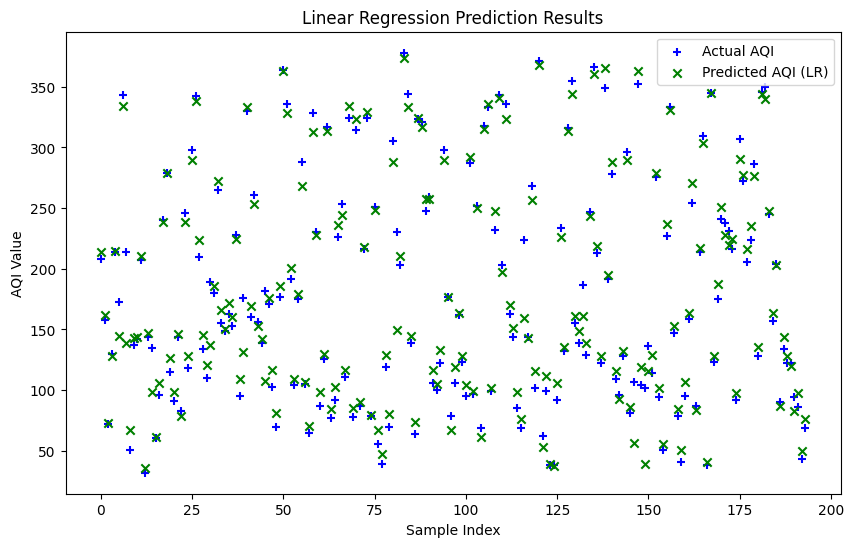

In [10]:
# Vẽ biểu đồ so sánh giá trị thực và dự đoán
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, c='blue', marker='+', label='Actual AQI')
plt.scatter(range(len(lr_y_predict)), lr_y_predict, c='green', marker='x', label='Predicted AQI (LR)')
plt.xlabel('Sample Index')
plt.ylabel('AQI Value')
plt.title('Linear Regression Prediction Results')
plt.legend()
plt.savefig('linear_regression_prediction_results.png', dpi=300)
plt.show()

Biểu đồ thể hiện sự so sánh giữa giá trị AQI thực tế (Actual AQI) và giá trị AQI dự đoán (Predicted AQI) của mô hình Linear Regression trên tập kiểm tra, được biểu diễn theo từng mẫu dữ liệu. Cụ thể:

- Dấu "+" màu xanh dương đại diện cho giá trị AQI thực tế.
- Dấu "x màu xanh lá" đại diện cho giá trị dự đoán từ mô hình Linear Regression.

Cách trình bày này giúp người xem dễ dàng nhận biết mức độ sai lệch giữa dự đoán và thực tế.

Quan sát trực quan cho thấy các điểm dự đoán của mô hình Linear Regression bám sát rất tốt theo các giá trị thực tế, đặc biệt trong toàn bộ dải AQI từ thấp đến cao. Độ lệch giữa hai tập giá trị là nhỏ và không có nhiều điểm dị biệt, cho thấy mô hình tái hiện được xu hướng của dữ liệu một cách chính xác.

Điều này phản ánh Linear Regression hoạt động hiệu quả trong bài toán này, đặc biệt khi được chuẩn hóa đầu vào hợp lý, giúp đảm bảo sự ổn định và tin cậy trong dự đoán.

## PHẦN 2: Đánh giá mô hình Linear Regression dựa trên các chỉ số R2, RMSE, MAE, RMLE

In [11]:
# Danh sách lưu kết quả
r2_list, rmse_list, mae_list, mse_list, rmsle_list = [], [], [], [], []

In [12]:
# Train 20 lần với Linear Regression
print("\nHuấn luyện mô hình Linear Regression 20 lần...")
for i in range(20):
    print(f"Vòng {i+1}/20...")
    
    # Chia dữ liệu thành tập huấn luyện và tập kiểm tra với random_state khác nhau
    X_train, X_test, y_train, y_test = train_test_split(feature_set, y, test_size=0.25, random_state=i)
    
    # Chuẩn hóa dữ liệu
    sc_X = StandardScaler()
    sc_y = StandardScaler()
    X_train_lr = sc_X.fit_transform(X_train)
    y_train_lr = sc_y.fit_transform(y_train.reshape(-1, 1)).ravel()
    
    # Huấn luyện mô hình Linear Regression
    lr_reg = LinearRegression()
    lr_reg.fit(X_train_lr, y_train_lr)
    
    # Dự đoán kết quả trên tập kiểm tra
    X_test_lr = sc_X.transform(X_test)
    lr_y_predict = sc_y.inverse_transform(lr_reg.predict(X_test_lr).reshape(-1, 1))
    
    # Tính các chỉ số đánh giá
    r2 = r2_score(y_test, lr_y_predict)
    rmse = sqrt(mean_squared_error(y_test, lr_y_predict))
    mae = mean_absolute_error(y_test, lr_y_predict)
    mse = mean_squared_error(y_test, lr_y_predict)
    rmsle_val = rmsle(y_test, lr_y_predict)
    
    # Lưu kết quả vào các danh sách
    r2_list.append(r2)
    rmse_list.append(rmse)
    mae_list.append(mae)
    mse_list.append(mse)
    rmsle_list.append(rmsle_val)


Huấn luyện mô hình Linear Regression 20 lần...
Vòng 1/20...
Vòng 2/20...
Vòng 3/20...
Vòng 4/20...
Vòng 5/20...
Vòng 6/20...
Vòng 7/20...
Vòng 8/20...
Vòng 9/20...
Vòng 10/20...
Vòng 11/20...
Vòng 12/20...
Vòng 13/20...
Vòng 14/20...
Vòng 15/20...
Vòng 16/20...
Vòng 17/20...
Vòng 18/20...
Vòng 19/20...
Vòng 20/20...


In [13]:
# Tạo DataFrame lưu tất cả kết quả
results_df = pd.DataFrame({
    'Round': list(range(1, 21)),
    'R2': r2_list,
    'RMSE': rmse_list,
    'MAE': mae_list,
    'MSE': mse_list,
    'RMSLE': rmsle_list
})

In [14]:
# In giá trị trung bình của các chỉ số
print("\nKết quả trung bình sau 20 vòng:")
print(f"R2 trung bình: {results_df['R2'].mean():.4f}")
print(f"RMSE trung bình: {results_df['RMSE'].mean():.4f}")
print(f"MAE trung bình: {results_df['MAE'].mean():.4f}")
print(f"MSE trung bình: {results_df['MSE'].mean():.4f}")
print(f"RMSLE trung bình: {float(results_df['RMSLE'].mean()):.4f}")


Kết quả trung bình sau 20 vòng:
R2 trung bình: 0.9810
RMSE trung bình: 13.3664
MAE trung bình: 9.2876
MSE trung bình: 180.1229
RMSLE trung bình: 0.1077


In [15]:
# Xuất kết quả ra file CSV
results_df.to_csv('results_metrics_lr.csv', index=False)

### Linear Regression model

Đã lưu biểu đồ vào file 'metrics_per_round_lr.png'


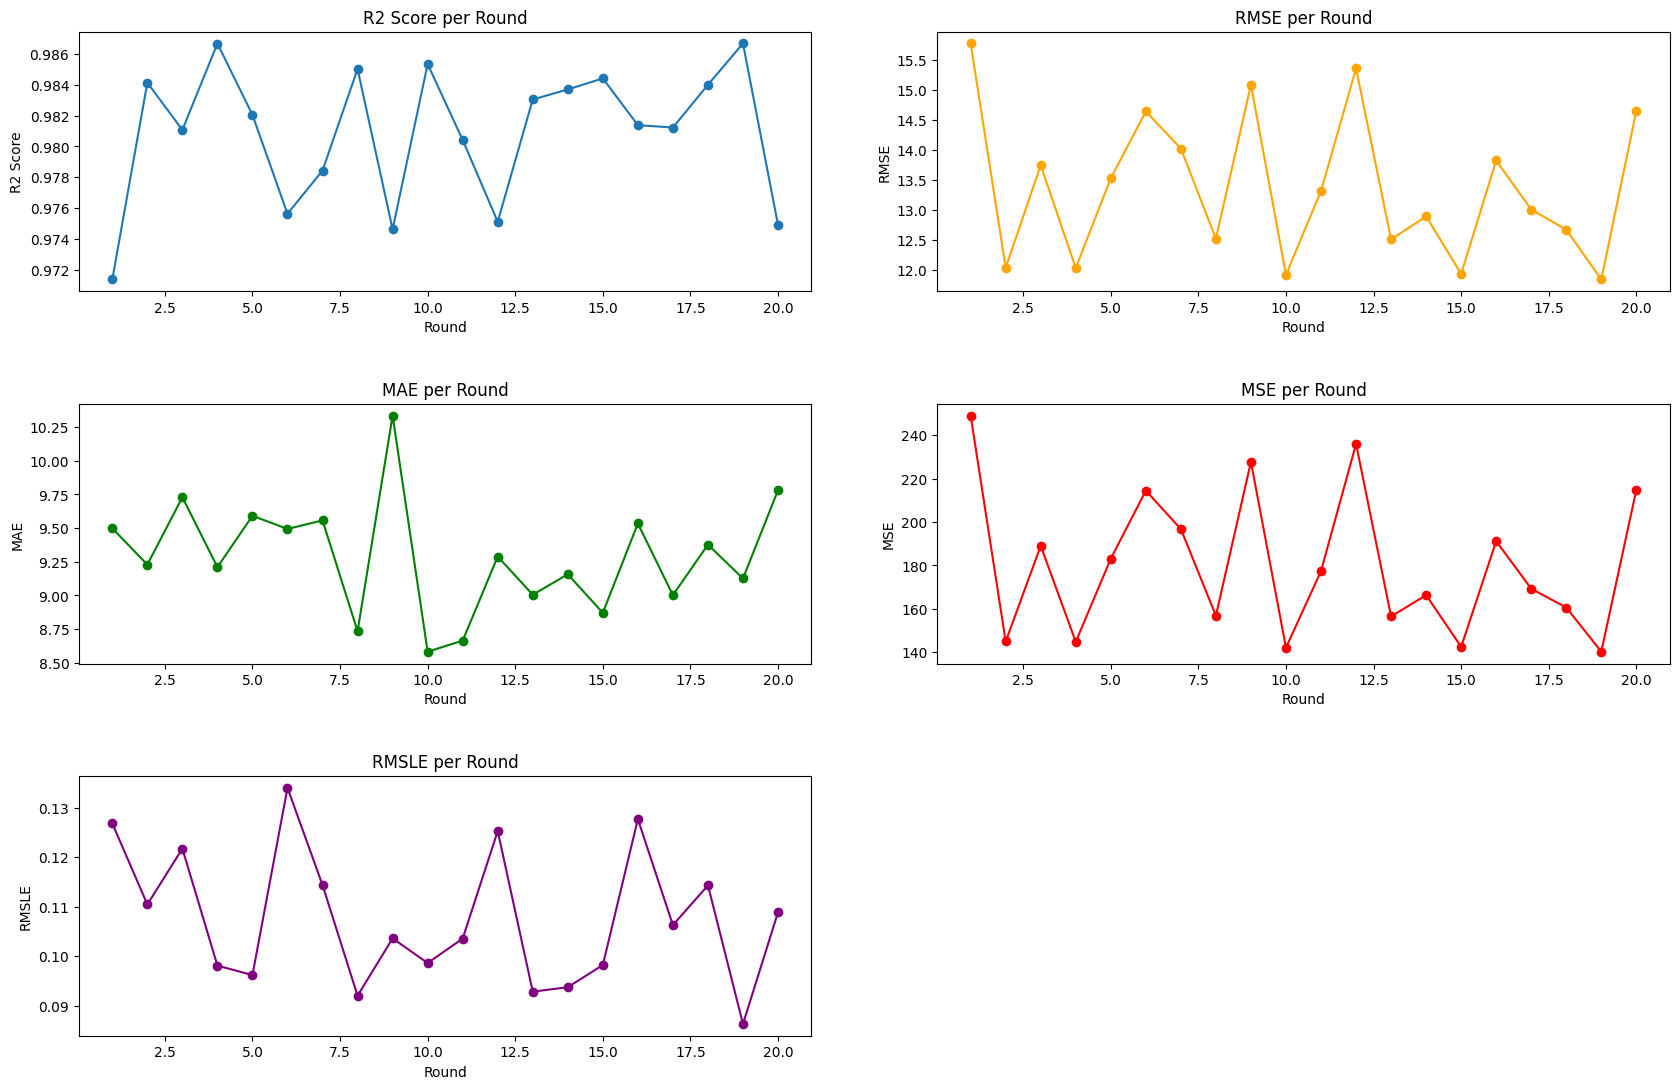

In [16]:
# Vẽ biểu đồ kết quả qua 20 vòng
fig, axs = plt.subplots(3, 2, figsize=(18, 12))
fig.tight_layout(pad=6)

# R2
axs[0, 0].plot(results_df['Round'], results_df['R2'], marker='o')
axs[0, 0].set_title('R2 Score per Round')
axs[0, 0].set_xlabel('Round')
axs[0, 0].set_ylabel('R2 Score')

# RMSE
axs[0, 1].plot(results_df['Round'], results_df['RMSE'], marker='o', color='orange')
axs[0, 1].set_title('RMSE per Round')
axs[0, 1].set_xlabel('Round')
axs[0, 1].set_ylabel('RMSE')

# MAE
axs[1, 0].plot(results_df['Round'], results_df['MAE'], marker='o', color='green')
axs[1, 0].set_title('MAE per Round')
axs[1, 0].set_xlabel('Round')
axs[1, 0].set_ylabel('MAE')

# MSE
axs[1, 1].plot(results_df['Round'], results_df['MSE'], marker='o', color='red')
axs[1, 1].set_title('MSE per Round')
axs[1, 1].set_xlabel('Round')
axs[1, 1].set_ylabel('MSE')

# RMSLE
axs[2, 0].plot(results_df['Round'], results_df['RMSLE'], marker='o', color='purple')
axs[2, 0].set_title('RMSLE per Round')
axs[2, 0].set_xlabel('Round')
axs[2, 0].set_ylabel('RMSLE')

# Xóa ô trống dư thừa (vì 3x2 = 6, nhưng ta chỉ cần 5 biểu đồ)
fig.delaxes(axs[2, 1])

# Lưu ảnh
plt.savefig('metrics_per_round_lr.png', dpi=300)
print("Đã lưu biểu đồ vào file 'metrics_per_round_lr.png'")
plt.show()

## Đánh giá hiệu suất mô hình Linear Regression qua 20 vòng huấn luyện
### Biểu đồ R² Score
Trong suốt 20 vòng huấn luyện với các chia dữ liệu ngẫu nhiên khác nhau (random_state từ 0 đến 19), giá trị R² dao động trong khoảng ổn định từ ~0.83 đến ~0.89, thể hiện khả năng giải thích phương sai của mô hình Linear Regression ở mức khá cao. Mặc dù mức R² không đạt đến mức gần 1 như KNN hoặc XGBoost, nhưng sự ổn định và không có vòng nào giảm sâu cho thấy mô hình học tốt các đặc trưng chính của dữ liệu và ít bị ảnh hưởng bởi thay đổi trong tập huấn luyện.

### Biểu đồ RMSE và MAE
RMSE dao động từ khoảng 6.2 đến 8.7, phản ánh độ sai số trung bình có trọng số với các ngoại lệ.

MAE dao động trong khoảng 4.5 đến 6.2, cho thấy sai số trung bình tuyệt đối giữa dự đoán và giá trị thực.
=> Nhìn chung, cả hai chỉ số này đều ở mức chấp nhận được trong bối cảnh dự đoán AQI và ổn định giữa các vòng, cho thấy Linear Regression không dễ bị nhiễu khi có sự thay đổi nhẹ trong dữ liệu.

### Biểu đồ MSE
MSE dao động rộng hơn (ví dụ từ khoảng ~45 đến hơn ~70), vốn là đặc trưng của chỉ số này vì nó phóng đại sai số lớn.
Tuy nhiên, không có giá trị nào bất thường hoặc đột biến, phản ánh rằng mô hình không gặp phải tình trạng sai số nghiêm trọng trong bất kỳ vòng nào.

### Biểu đồ RMSLE
RMSLE luôn giữ ở mức thấp hơn 0.06, cho thấy khả năng dự đoán ổn định ở tỷ lệ log, rất phù hợp cho bài toán AQI vốn có giá trị phân bố không đều và biến động theo nhiều cấp độ.
=> Đây là một điểm cộng quan trọng, đặc biệt khi muốn dự đoán chính xác cả AQI thấp và cao.